In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from WindPy import w
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from adjustText import adjust_text
%matplotlib inline

In [55]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

# 信用债

In [56]:
bcodes = ['CBA01201.CS', # 金融债
          'CBA04201.CS', # AAA
          'CBA04101.CS', # AA+
          'CBA04001.CS', # AA
          'CBA03901.CS', # AA-
          'CBA07501.CS', # 同业存单
          'CBA02601.CS', # 中票
          'CBA04401.CS', # 地方政府
          'CBA05301.CS', # ABS
         ]
bnames = ['金融债', 'AAA企业债', 'AA+企业债', 'AA企业债', 'AA-企业债', '同业存单', '中期票据', '地方政府债', 'ABS']
bdf = pd.DataFrame({'wind_code': bcodes, 'sec_name': bnames})

In [57]:
data = w.wss(bcodes, "risk_returnyearly_index,stdevry","startDate=20160101;endDate=20200617;returnType=1;period=2")

In [58]:
bret_vol = pd.DataFrame(np.array(data.Data).T, columns=['ret', 'vol'])

In [59]:
bdf = pd.concat([bdf, bret_vol], axis=1)

In [60]:
bdf

,wind_code,sec_name,ret,vol
0,CBA01201.CS,金融债,3.788958,2.185135
1,CBA04201.CS,AAA企业债,4.006232,1.831663
2,CBA04101.CS,AA+企业债,4.721779,1.527515
3,CBA04001.CS,AA企业债,5.241536,1.592842
4,CBA03901.CS,AA-企业债,5.999439,1.686812
5,CBA07501.CS,同业存单,3.708814,0.350370
6,CBA02601.CS,中期票据,4.381616,1.493342
7,CBA04401.CS,地方政府债,3.633893,1.684270
8,CBA05301.CS,ABS,4.935102,1.181785


# 申万行业

In [61]:
# data = w.wset("sectorconstituent","sectorid=a39901011i000000;field=wind_code,sec_name") ## 申万三级行业
data = w.wset("sectorconstituent","sectorid=a39901011h000000;field=wind_code,sec_name") ## 申万二级行业
# data = w.wset("sectorconstituent","sectorid=a39901011g000000;field=wind_code,sec_name") ## 申万一级行业

In [62]:
sectors = pd.DataFrame(np.array(data.Data).T, columns=data.Fields)

In [128]:
data = w.wss(sectors['wind_code'].tolist(), "risk_returnyearly_index,stdevry","startDate=20150101;endDate=20200706;returnType=1;period=2")

In [129]:
ret_vol = pd.DataFrame(np.array(data.Data).T, columns=['ret', 'vol'])

In [130]:
df = pd.concat([sectors, ret_vol], axis=1)

In [131]:
df = df.dropna()
df.index = np.arange(df.shape[0])

In [132]:
df.head()

,wind_code,sec_name,ret,vol
0,801011.SI,林业Ⅱ(申万),-12.579784,43.471130
1,801012.SI,农产品加工(申万),5.307490,33.156283
2,801013.SI,农业综合Ⅱ(申万),-7.341624,48.058690
3,801014.SI,饲料Ⅱ(申万),26.076503,35.657262
4,801015.SI,渔业(申万),-9.759268,34.413057


In [133]:
df.shape

(102, 4)

In [134]:
# df.to_excel('../data/申万三级行业风险收益特征.xlsx', index=False)

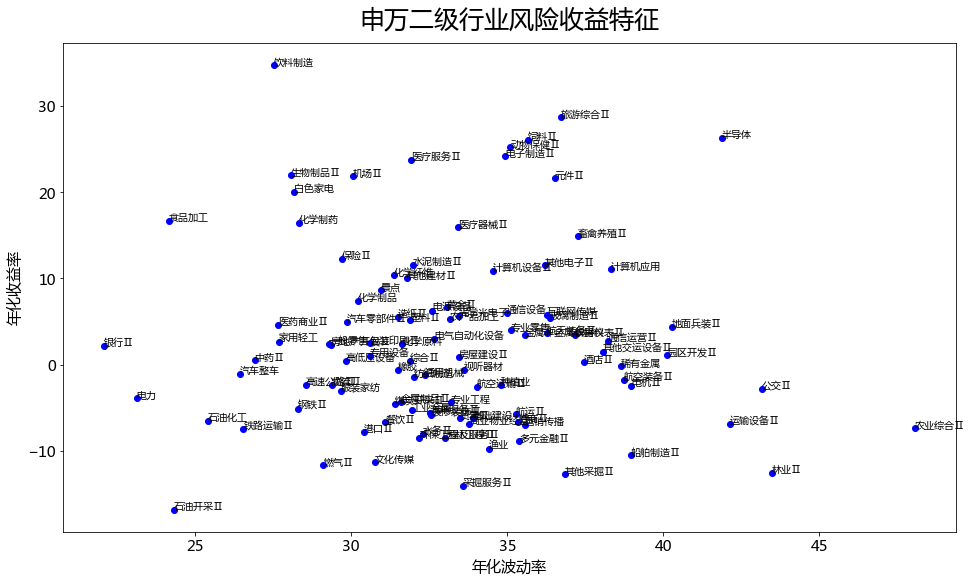

In [136]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.scatter(df['vol'], df['ret'], color='blue')

# for i, txt in enumerate(df['sec_name']):
#     ax.annotate(txt.rstrip('(申万)'), (df['vol'][i], df['ret'][i]), fontsize=10)
texts = [ax.text(df['vol'][i], df['ret'][i], df['sec_name'][i].rstrip('(申万)')) for i in range(df.shape[0])]
# adjust_text(texts)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('年化收益率', fontsize=15)
ax.set_xlabel('年化波动率', fontsize=15)
_ = ax.set_title(u'申万二级行业风险收益特征', fontsize=25, y=1.02)
fig.savefig('C:/Users/zhangyang01/Desktop/申万二级行业风险收益特征.png', format='png', dpi=400, bbox_inches='tight')

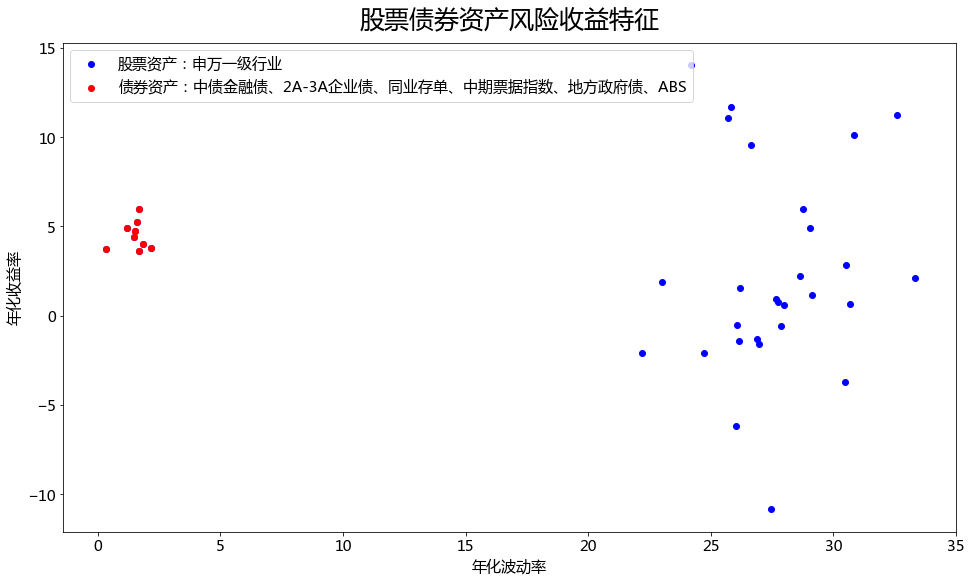

In [239]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.scatter(df['vol'], df['ret'], color='blue', label='股票资产：申万一级行业')
ax.scatter(bret_vol['vol'], bret_vol['ret'], color='red', label='债券资产：中债金融债、2A-3A企业债、同业存单、中期票据指数、地方政府债、ABS')

ax.legend(fontsize=15, loc='upper left')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('年化收益率', fontsize=15)
ax.set_xlabel('年化波动率', fontsize=15)
_ = ax.set_title(u'股票债券资产风险收益特征', fontsize=25, y=1.02)

In [227]:
df = bdf.append(df)

In [228]:
data = w.wsd(df['wind_code'].tolist(), 'close', '2020-01-01', '2020-06-01')

In [229]:
prices = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [230]:
X = prices.pct_change().dropna().values.T

In [231]:
# km = TimeSeriesKMeans(n_clusters=6, metric='euclidean', max_iter=5, random_state=0).fit(X)
model = AgglomerativeClustering(n_clusters=7)

In [232]:
df['cluster'] = model.fit_predict(X)

In [237]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    dendrogram(linkage_matrix, **kwargs)
    fig.savefig('../data/底层资产聚类.png', format='png', dpi=400, bbox_inches='tight')

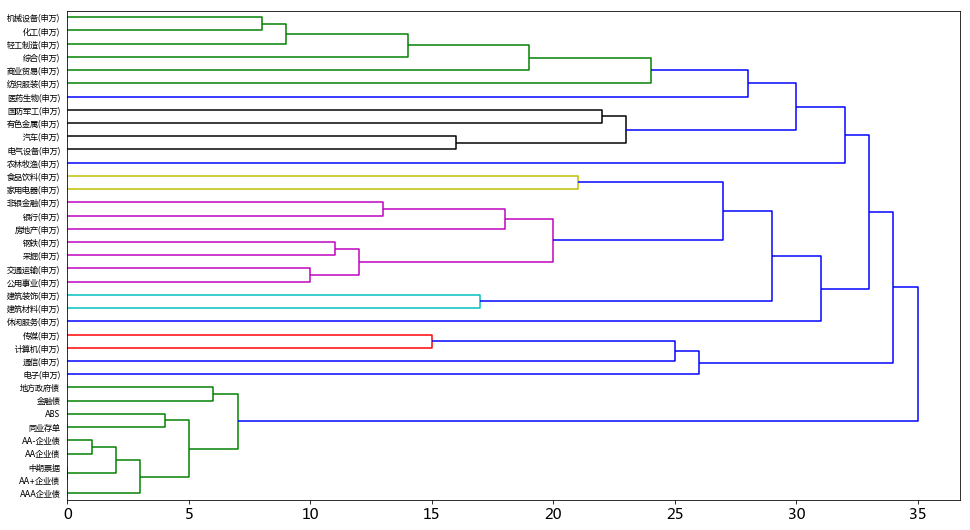

In [238]:
plot_dendrogram(model, labels=df['sec_name'].tolist(), orientation='right')